## Importing Libraries

In [90]:
###########################
## Import Torch Libaries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
###########################
## Import standard libaries
import pandas as pd
import numpy as np
import os
import random
##########################
## Import PIL
from PIL import Image

#####################
## import SK learn libaries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
####################
## import matplot
import matplotlib.pyplot as plt


In [91]:
#####################
##Enable CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Figuring out the dimension of the images

In [92]:
#################################
folder_path = './Images'

# Define a transform without resizing (to maintain original dimensions)
transform = transforms.Compose([transforms.ToTensor()])

# Create an ImageFolder dataset
dataset = ImageFolder(root=folder_path, transform=transform)

# Choose an index for the image you want to check
index_to_check = 0

# Retrieve the image and its dimensions
image, label = dataset[index_to_check]
original_dimensions = image.shape

# Print the original dimensions
print(f"Original dimensions of the image: {original_dimensions}")


Original dimensions of the image: torch.Size([3, 48, 48])


## Mapping labels with images

In [93]:
##########################################
class EmotionDetection(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = os.listdir(data_path)
        ## make an array for images and labls
        self.images = []
        self.labels = []
        ## iterate through emotion class
        for i, emotion_class in enumerate(self.classes):
            ### grab all images in folders
            class_path = os.path.join(data_path, emotion_class)
            ## iterate image_name in path
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]

        # Open the image
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Convert label to a single index
        label = torch.tensor(label, dtype=torch.long)

        return image, label




In [94]:
##############################
data_path = './Images'  
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

dataset = EmotionDetection(data_path=data_path, transform=transform)
##############################

In [95]:
##############################
index = 0
image, label = dataset[index]
##############################

In [96]:
##############################
image.shape
##############################

torch.Size([3, 48, 48])

In [97]:

## labell are based on the directory name
# which means 0 is the first folder name, 
#1 is the second folder name, etc.
label 


tensor(0)

## View Class

In [98]:
######################
## View Class
class View(nn.Module):
    
    def __init__(self, shape):
        
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)


## Model

In [99]:

class Classifier_CNN_3_Layers(nn.Module):
    def __init__(self):
        super(Classifier_CNN_3_Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        ## flatten and connect all layers
        x = x.view(-1, 256 * 6 * 6)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # Softmax activation for multiclass classification
        return F.softmax(x, dim=1) 




## Splitting the dataset into training and testing


In [100]:

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


## Creating dataloader

In [101]:
##############################
batch_size = 32

# Create DataLoader instances for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##############################

## Run Model

In [102]:

%%time
cnn_classifier = Classifier_CNN_3_Layers().to(device)  
# Update the model accordingly

optimizer = optim.SGD(cnn_classifier.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss() 

epochs = 100

for epoch in range(epochs):
    # Training
    cnn_classifier.train()
    ## iterate through images in labels in train data loader
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        ### zero out gradients
        optimizer.zero_grad()
        outputs = cnn_classifier(images)
        
        # Uncomment or comment to control predicted prints
        # print("Predictions:", torch.argmax(outputs, dim=1))
        # print("True Labels:", labels)
        loss = criterion(outputs, labels)
        ## send update weights
        loss.backward()
        ## 
        optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Iteration {i + 1}/{len(train_loader)}, Loss: {loss.item()}")



Epoch 1/100, Iteration 1/38, Loss: 1.0987522602081299
Epoch 1/100, Iteration 2/38, Loss: 1.0993735790252686
Epoch 1/100, Iteration 3/38, Loss: 1.098507285118103
Epoch 1/100, Iteration 4/38, Loss: 1.0967859029769897
Epoch 1/100, Iteration 5/38, Loss: 1.0966240167617798
Epoch 1/100, Iteration 6/38, Loss: 1.0976617336273193
Epoch 1/100, Iteration 7/38, Loss: 1.095979928970337
Epoch 1/100, Iteration 8/38, Loss: 1.0971640348434448
Epoch 1/100, Iteration 9/38, Loss: 1.1010545492172241
Epoch 1/100, Iteration 10/38, Loss: 1.0936044454574585
Epoch 1/100, Iteration 11/38, Loss: 1.1015779972076416
Epoch 1/100, Iteration 12/38, Loss: 1.1061934232711792
Epoch 1/100, Iteration 13/38, Loss: 1.0966212749481201
Epoch 1/100, Iteration 14/38, Loss: 1.0963484048843384
Epoch 1/100, Iteration 15/38, Loss: 1.1000049114227295
Epoch 1/100, Iteration 16/38, Loss: 1.0990517139434814
Epoch 1/100, Iteration 17/38, Loss: 1.1020615100860596
Epoch 1/100, Iteration 18/38, Loss: 1.0989360809326172
Epoch 1/100, Iteratio

Epoch 5/100, Iteration 2/38, Loss: 1.1036568880081177
Epoch 5/100, Iteration 3/38, Loss: 1.0927575826644897
Epoch 5/100, Iteration 4/38, Loss: 1.0969583988189697
Epoch 5/100, Iteration 5/38, Loss: 1.0926498174667358
Epoch 5/100, Iteration 6/38, Loss: 1.1022340059280396
Epoch 5/100, Iteration 7/38, Loss: 1.0959668159484863
Epoch 5/100, Iteration 8/38, Loss: 1.10128915309906
Epoch 5/100, Iteration 9/38, Loss: 1.0965665578842163
Epoch 5/100, Iteration 10/38, Loss: 1.0971121788024902
Epoch 5/100, Iteration 11/38, Loss: 1.091583251953125
Epoch 5/100, Iteration 12/38, Loss: 1.1013338565826416
Epoch 5/100, Iteration 13/38, Loss: 1.1002355813980103
Epoch 5/100, Iteration 14/38, Loss: 1.094670295715332
Epoch 5/100, Iteration 15/38, Loss: 1.1022403240203857
Epoch 5/100, Iteration 16/38, Loss: 1.0987299680709839
Epoch 5/100, Iteration 17/38, Loss: 1.0938986539840698
Epoch 5/100, Iteration 18/38, Loss: 1.0940907001495361
Epoch 5/100, Iteration 19/38, Loss: 1.0979127883911133
Epoch 5/100, Iteration

Epoch 9/100, Iteration 1/38, Loss: 1.1033086776733398
Epoch 9/100, Iteration 2/38, Loss: 1.0934325456619263
Epoch 9/100, Iteration 3/38, Loss: 1.0998625755310059
Epoch 9/100, Iteration 4/38, Loss: 1.0838370323181152
Epoch 9/100, Iteration 5/38, Loss: 1.0857588052749634
Epoch 9/100, Iteration 6/38, Loss: 1.0820995569229126
Epoch 9/100, Iteration 7/38, Loss: 1.099389910697937
Epoch 9/100, Iteration 8/38, Loss: 1.1124494075775146
Epoch 9/100, Iteration 9/38, Loss: 1.1023406982421875
Epoch 9/100, Iteration 10/38, Loss: 1.092738151550293
Epoch 9/100, Iteration 11/38, Loss: 1.0906915664672852
Epoch 9/100, Iteration 12/38, Loss: 1.0891541242599487
Epoch 9/100, Iteration 13/38, Loss: 1.092386245727539
Epoch 9/100, Iteration 14/38, Loss: 1.0881762504577637
Epoch 9/100, Iteration 15/38, Loss: 1.0910083055496216
Epoch 9/100, Iteration 16/38, Loss: 1.0954043865203857
Epoch 9/100, Iteration 17/38, Loss: 1.0981124639511108
Epoch 9/100, Iteration 18/38, Loss: 1.0966637134552002
Epoch 9/100, Iteration

Epoch 12/100, Iteration 37/38, Loss: 1.1037369966506958
Epoch 12/100, Iteration 38/38, Loss: 1.082364559173584
Epoch 13/100, Iteration 1/38, Loss: 1.0918837785720825
Epoch 13/100, Iteration 2/38, Loss: 1.080838918685913
Epoch 13/100, Iteration 3/38, Loss: 1.0709891319274902
Epoch 13/100, Iteration 4/38, Loss: 1.105708360671997
Epoch 13/100, Iteration 5/38, Loss: 1.0840033292770386
Epoch 13/100, Iteration 6/38, Loss: 1.1176432371139526
Epoch 13/100, Iteration 7/38, Loss: 1.0940353870391846
Epoch 13/100, Iteration 8/38, Loss: 1.1057820320129395
Epoch 13/100, Iteration 9/38, Loss: 1.0752590894699097
Epoch 13/100, Iteration 10/38, Loss: 1.075276494026184
Epoch 13/100, Iteration 11/38, Loss: 1.0808693170547485
Epoch 13/100, Iteration 12/38, Loss: 1.1023128032684326
Epoch 13/100, Iteration 13/38, Loss: 1.0891114473342896
Epoch 13/100, Iteration 14/38, Loss: 1.0710551738739014
Epoch 13/100, Iteration 15/38, Loss: 1.0705952644348145
Epoch 13/100, Iteration 16/38, Loss: 1.085893988609314
Epoch 

Epoch 16/100, Iteration 33/38, Loss: 1.0348573923110962
Epoch 16/100, Iteration 34/38, Loss: 1.055853247642517
Epoch 16/100, Iteration 35/38, Loss: 1.0887961387634277
Epoch 16/100, Iteration 36/38, Loss: 1.1021441221237183
Epoch 16/100, Iteration 37/38, Loss: 0.9905057549476624
Epoch 16/100, Iteration 38/38, Loss: 1.0867127180099487
Epoch 17/100, Iteration 1/38, Loss: 1.1237578392028809
Epoch 17/100, Iteration 2/38, Loss: 1.0630134344100952
Epoch 17/100, Iteration 3/38, Loss: 1.0138473510742188
Epoch 17/100, Iteration 4/38, Loss: 1.0384573936462402
Epoch 17/100, Iteration 5/38, Loss: 0.9842451214790344
Epoch 17/100, Iteration 6/38, Loss: 1.0635805130004883
Epoch 17/100, Iteration 7/38, Loss: 1.1358336210250854
Epoch 17/100, Iteration 8/38, Loss: 1.0615065097808838
Epoch 17/100, Iteration 9/38, Loss: 1.033698558807373
Epoch 17/100, Iteration 10/38, Loss: 1.1683825254440308
Epoch 17/100, Iteration 11/38, Loss: 1.0690761804580688
Epoch 17/100, Iteration 12/38, Loss: 1.10080885887146
Epoch

Epoch 20/100, Iteration 30/38, Loss: 1.050193190574646
Epoch 20/100, Iteration 31/38, Loss: 1.0527302026748657
Epoch 20/100, Iteration 32/38, Loss: 1.1767746210098267
Epoch 20/100, Iteration 33/38, Loss: 1.0733404159545898
Epoch 20/100, Iteration 34/38, Loss: 1.0602879524230957
Epoch 20/100, Iteration 35/38, Loss: 1.1097495555877686
Epoch 20/100, Iteration 36/38, Loss: 1.0284942388534546
Epoch 20/100, Iteration 37/38, Loss: 1.0041905641555786
Epoch 20/100, Iteration 38/38, Loss: 1.0788733959197998
Epoch 21/100, Iteration 1/38, Loss: 1.07753324508667
Epoch 21/100, Iteration 2/38, Loss: 1.0868276357650757
Epoch 21/100, Iteration 3/38, Loss: 1.0701099634170532
Epoch 21/100, Iteration 4/38, Loss: 1.0656752586364746
Epoch 21/100, Iteration 5/38, Loss: 1.034180998802185
Epoch 21/100, Iteration 6/38, Loss: 1.0772955417633057
Epoch 21/100, Iteration 7/38, Loss: 0.9790307283401489
Epoch 21/100, Iteration 8/38, Loss: 1.158502221107483
Epoch 21/100, Iteration 9/38, Loss: 1.1174635887145996
Epoch 

Epoch 24/100, Iteration 26/38, Loss: 1.0646743774414062
Epoch 24/100, Iteration 27/38, Loss: 1.0547571182250977
Epoch 24/100, Iteration 28/38, Loss: 1.057906985282898
Epoch 24/100, Iteration 29/38, Loss: 1.048778772354126
Epoch 24/100, Iteration 30/38, Loss: 1.0958375930786133
Epoch 24/100, Iteration 31/38, Loss: 1.061188817024231
Epoch 24/100, Iteration 32/38, Loss: 1.0242351293563843
Epoch 24/100, Iteration 33/38, Loss: 1.0637784004211426
Epoch 24/100, Iteration 34/38, Loss: 0.9818851351737976
Epoch 24/100, Iteration 35/38, Loss: 1.0019867420196533
Epoch 24/100, Iteration 36/38, Loss: 1.0302321910858154
Epoch 24/100, Iteration 37/38, Loss: 1.1158016920089722
Epoch 24/100, Iteration 38/38, Loss: 1.0515739917755127
Epoch 25/100, Iteration 1/38, Loss: 1.0770264863967896
Epoch 25/100, Iteration 2/38, Loss: 1.0263848304748535
Epoch 25/100, Iteration 3/38, Loss: 1.0506417751312256
Epoch 25/100, Iteration 4/38, Loss: 1.112787127494812
Epoch 25/100, Iteration 5/38, Loss: 1.079633116722107
Ep

Epoch 28/100, Iteration 23/38, Loss: 1.044751763343811
Epoch 28/100, Iteration 24/38, Loss: 0.9819455146789551
Epoch 28/100, Iteration 25/38, Loss: 1.030385971069336
Epoch 28/100, Iteration 26/38, Loss: 0.906139612197876
Epoch 28/100, Iteration 27/38, Loss: 1.0630242824554443
Epoch 28/100, Iteration 28/38, Loss: 1.0144933462142944
Epoch 28/100, Iteration 29/38, Loss: 1.0163214206695557
Epoch 28/100, Iteration 30/38, Loss: 1.0182650089263916
Epoch 28/100, Iteration 31/38, Loss: 0.9861479997634888
Epoch 28/100, Iteration 32/38, Loss: 1.0069586038589478
Epoch 28/100, Iteration 33/38, Loss: 0.9983333945274353
Epoch 28/100, Iteration 34/38, Loss: 1.077676773071289
Epoch 28/100, Iteration 35/38, Loss: 1.0892852544784546
Epoch 28/100, Iteration 36/38, Loss: 1.0073316097259521
Epoch 28/100, Iteration 37/38, Loss: 1.1679155826568604
Epoch 28/100, Iteration 38/38, Loss: 0.9995415806770325
Epoch 29/100, Iteration 1/38, Loss: 0.9620580673217773
Epoch 29/100, Iteration 2/38, Loss: 1.093758344650268

Epoch 32/100, Iteration 21/38, Loss: 0.9511170387268066
Epoch 32/100, Iteration 22/38, Loss: 0.9803724884986877
Epoch 32/100, Iteration 23/38, Loss: 0.9355993866920471
Epoch 32/100, Iteration 24/38, Loss: 1.0263876914978027
Epoch 32/100, Iteration 25/38, Loss: 0.9521530866622925
Epoch 32/100, Iteration 26/38, Loss: 1.0065176486968994
Epoch 32/100, Iteration 27/38, Loss: 1.0436161756515503
Epoch 32/100, Iteration 28/38, Loss: 0.936253547668457
Epoch 32/100, Iteration 29/38, Loss: 1.023919939994812
Epoch 32/100, Iteration 30/38, Loss: 1.0802114009857178
Epoch 32/100, Iteration 31/38, Loss: 0.9777281284332275
Epoch 32/100, Iteration 32/38, Loss: 0.9178277850151062
Epoch 32/100, Iteration 33/38, Loss: 1.067418098449707
Epoch 32/100, Iteration 34/38, Loss: 1.0324010848999023
Epoch 32/100, Iteration 35/38, Loss: 0.9913948774337769
Epoch 32/100, Iteration 36/38, Loss: 1.0109918117523193
Epoch 32/100, Iteration 37/38, Loss: 0.870185911655426
Epoch 32/100, Iteration 38/38, Loss: 0.8200855255126

Epoch 36/100, Iteration 18/38, Loss: 0.96180260181427
Epoch 36/100, Iteration 19/38, Loss: 1.0466580390930176
Epoch 36/100, Iteration 20/38, Loss: 0.9710838794708252
Epoch 36/100, Iteration 21/38, Loss: 1.0114047527313232
Epoch 36/100, Iteration 22/38, Loss: 0.8829113245010376
Epoch 36/100, Iteration 23/38, Loss: 1.0403752326965332
Epoch 36/100, Iteration 24/38, Loss: 0.8425211906433105
Epoch 36/100, Iteration 25/38, Loss: 1.0784651041030884
Epoch 36/100, Iteration 26/38, Loss: 1.0370734930038452
Epoch 36/100, Iteration 27/38, Loss: 0.873657763004303
Epoch 36/100, Iteration 28/38, Loss: 0.9210882186889648
Epoch 36/100, Iteration 29/38, Loss: 0.8161748647689819
Epoch 36/100, Iteration 30/38, Loss: 0.9792763590812683
Epoch 36/100, Iteration 31/38, Loss: 1.0223901271820068
Epoch 36/100, Iteration 32/38, Loss: 0.9404082298278809
Epoch 36/100, Iteration 33/38, Loss: 0.9076067805290222
Epoch 36/100, Iteration 34/38, Loss: 1.0475598573684692
Epoch 36/100, Iteration 35/38, Loss: 1.028023242950

Epoch 40/100, Iteration 23/38, Loss: 0.9432430863380432
Epoch 40/100, Iteration 24/38, Loss: 1.0372401475906372
Epoch 40/100, Iteration 25/38, Loss: 0.9390869140625
Epoch 40/100, Iteration 26/38, Loss: 0.9692628979682922
Epoch 40/100, Iteration 27/38, Loss: 0.9570208191871643
Epoch 40/100, Iteration 28/38, Loss: 0.8560559153556824
Epoch 40/100, Iteration 29/38, Loss: 0.9686801433563232
Epoch 40/100, Iteration 30/38, Loss: 0.8424633145332336
Epoch 40/100, Iteration 31/38, Loss: 0.9650067090988159
Epoch 40/100, Iteration 32/38, Loss: 0.9112768769264221
Epoch 40/100, Iteration 33/38, Loss: 1.0246365070343018
Epoch 40/100, Iteration 34/38, Loss: 0.7736160159111023
Epoch 40/100, Iteration 35/38, Loss: 0.9259162545204163
Epoch 40/100, Iteration 36/38, Loss: 0.8537166714668274
Epoch 40/100, Iteration 37/38, Loss: 0.8636981248855591
Epoch 40/100, Iteration 38/38, Loss: 0.8311017751693726
Epoch 41/100, Iteration 1/38, Loss: 0.8773190975189209
Epoch 41/100, Iteration 2/38, Loss: 0.93456739187240

Epoch 44/100, Iteration 20/38, Loss: 0.8552477359771729
Epoch 44/100, Iteration 21/38, Loss: 0.7726690173149109
Epoch 44/100, Iteration 22/38, Loss: 0.8500679135322571
Epoch 44/100, Iteration 23/38, Loss: 0.7617373466491699
Epoch 44/100, Iteration 24/38, Loss: 0.9315295219421387
Epoch 44/100, Iteration 25/38, Loss: 0.8679707646369934
Epoch 44/100, Iteration 26/38, Loss: 0.8757904171943665
Epoch 44/100, Iteration 27/38, Loss: 0.8650168180465698
Epoch 44/100, Iteration 28/38, Loss: 0.9091101884841919
Epoch 44/100, Iteration 29/38, Loss: 1.0462137460708618
Epoch 44/100, Iteration 30/38, Loss: 0.8337926864624023
Epoch 44/100, Iteration 31/38, Loss: 1.0147552490234375
Epoch 44/100, Iteration 32/38, Loss: 0.9632304906845093
Epoch 44/100, Iteration 33/38, Loss: 0.8746333718299866
Epoch 44/100, Iteration 34/38, Loss: 0.9544141888618469
Epoch 44/100, Iteration 35/38, Loss: 1.0526127815246582
Epoch 44/100, Iteration 36/38, Loss: 0.8189140558242798
Epoch 44/100, Iteration 37/38, Loss: 0.904008448

Epoch 48/100, Iteration 22/38, Loss: 0.8217691779136658
Epoch 48/100, Iteration 23/38, Loss: 0.8508680462837219
Epoch 48/100, Iteration 24/38, Loss: 0.8881112933158875
Epoch 48/100, Iteration 25/38, Loss: 0.9306352138519287
Epoch 48/100, Iteration 26/38, Loss: 0.7273693084716797
Epoch 48/100, Iteration 27/38, Loss: 0.7771380543708801
Epoch 48/100, Iteration 28/38, Loss: 0.8894051313400269
Epoch 48/100, Iteration 29/38, Loss: 0.8492679595947266
Epoch 48/100, Iteration 30/38, Loss: 0.7656720876693726
Epoch 48/100, Iteration 31/38, Loss: 0.819784939289093
Epoch 48/100, Iteration 32/38, Loss: 0.8209732174873352
Epoch 48/100, Iteration 33/38, Loss: 0.7874785661697388
Epoch 48/100, Iteration 34/38, Loss: 0.8902745842933655
Epoch 48/100, Iteration 35/38, Loss: 0.8595635294914246
Epoch 48/100, Iteration 36/38, Loss: 0.8161245584487915
Epoch 48/100, Iteration 37/38, Loss: 0.952817976474762
Epoch 48/100, Iteration 38/38, Loss: 0.8824360966682434
Epoch 49/100, Iteration 1/38, Loss: 0.970382094383

Epoch 52/100, Iteration 22/38, Loss: 0.7991806864738464
Epoch 52/100, Iteration 23/38, Loss: 0.7337936162948608
Epoch 52/100, Iteration 24/38, Loss: 0.9162099957466125
Epoch 52/100, Iteration 25/38, Loss: 0.7897281050682068
Epoch 52/100, Iteration 26/38, Loss: 0.8196683526039124
Epoch 52/100, Iteration 27/38, Loss: 0.7741267085075378
Epoch 52/100, Iteration 28/38, Loss: 0.6905685067176819
Epoch 52/100, Iteration 29/38, Loss: 0.7499306201934814
Epoch 52/100, Iteration 30/38, Loss: 0.781880795955658
Epoch 52/100, Iteration 31/38, Loss: 0.7375226616859436
Epoch 52/100, Iteration 32/38, Loss: 0.8771677613258362
Epoch 52/100, Iteration 33/38, Loss: 0.8498626947402954
Epoch 52/100, Iteration 34/38, Loss: 0.8397127985954285
Epoch 52/100, Iteration 35/38, Loss: 0.7700504660606384
Epoch 52/100, Iteration 36/38, Loss: 0.897921621799469
Epoch 52/100, Iteration 37/38, Loss: 0.7988505363464355
Epoch 52/100, Iteration 38/38, Loss: 0.6346842646598816
Epoch 53/100, Iteration 1/38, Loss: 0.797516703605

Epoch 56/100, Iteration 24/38, Loss: 0.780285120010376
Epoch 56/100, Iteration 25/38, Loss: 0.8552166223526001
Epoch 56/100, Iteration 26/38, Loss: 0.7452706694602966
Epoch 56/100, Iteration 27/38, Loss: 0.7778919339179993
Epoch 56/100, Iteration 28/38, Loss: 0.8293855786323547
Epoch 56/100, Iteration 29/38, Loss: 0.814228355884552
Epoch 56/100, Iteration 30/38, Loss: 0.7589678764343262
Epoch 56/100, Iteration 31/38, Loss: 0.8835257291793823
Epoch 56/100, Iteration 32/38, Loss: 0.937584638595581
Epoch 56/100, Iteration 33/38, Loss: 0.8043020367622375
Epoch 56/100, Iteration 34/38, Loss: 0.7877626419067383
Epoch 56/100, Iteration 35/38, Loss: 0.7975913882255554
Epoch 56/100, Iteration 36/38, Loss: 0.7084516286849976
Epoch 56/100, Iteration 37/38, Loss: 0.7223066091537476
Epoch 56/100, Iteration 38/38, Loss: 0.7499370574951172
Epoch 57/100, Iteration 1/38, Loss: 0.8340199589729309
Epoch 57/100, Iteration 2/38, Loss: 0.867821991443634
Epoch 57/100, Iteration 3/38, Loss: 0.8341296315193176

Epoch 60/100, Iteration 27/38, Loss: 0.8277713656425476
Epoch 60/100, Iteration 28/38, Loss: 0.7499425411224365
Epoch 60/100, Iteration 29/38, Loss: 0.6547642350196838
Epoch 60/100, Iteration 30/38, Loss: 0.7556192874908447
Epoch 60/100, Iteration 31/38, Loss: 0.7164149880409241
Epoch 60/100, Iteration 32/38, Loss: 0.7108349204063416
Epoch 60/100, Iteration 33/38, Loss: 0.7872022986412048
Epoch 60/100, Iteration 34/38, Loss: 0.7359662652015686
Epoch 60/100, Iteration 35/38, Loss: 0.868578314781189
Epoch 60/100, Iteration 36/38, Loss: 0.7881834506988525
Epoch 60/100, Iteration 37/38, Loss: 0.7220909595489502
Epoch 60/100, Iteration 38/38, Loss: 0.6555582284927368
Epoch 61/100, Iteration 1/38, Loss: 0.7683213949203491
Epoch 61/100, Iteration 2/38, Loss: 0.7618809938430786
Epoch 61/100, Iteration 3/38, Loss: 0.6748865842819214
Epoch 61/100, Iteration 4/38, Loss: 0.7055954933166504
Epoch 61/100, Iteration 5/38, Loss: 0.706509530544281
Epoch 61/100, Iteration 6/38, Loss: 0.6752442121505737


Epoch 64/100, Iteration 28/38, Loss: 0.6212101578712463
Epoch 64/100, Iteration 29/38, Loss: 0.6295968890190125
Epoch 64/100, Iteration 30/38, Loss: 0.6874189376831055
Epoch 64/100, Iteration 31/38, Loss: 0.6606851816177368
Epoch 64/100, Iteration 32/38, Loss: 0.6885613799095154
Epoch 64/100, Iteration 33/38, Loss: 0.6586999297142029
Epoch 64/100, Iteration 34/38, Loss: 0.759547233581543
Epoch 64/100, Iteration 35/38, Loss: 0.7504300475120544
Epoch 64/100, Iteration 36/38, Loss: 0.702536404132843
Epoch 64/100, Iteration 37/38, Loss: 0.8459904789924622
Epoch 64/100, Iteration 38/38, Loss: 0.6297574043273926
Epoch 65/100, Iteration 1/38, Loss: 0.747808575630188
Epoch 65/100, Iteration 2/38, Loss: 0.7001772522926331
Epoch 65/100, Iteration 3/38, Loss: 0.716505229473114
Epoch 65/100, Iteration 4/38, Loss: 0.8010878562927246
Epoch 65/100, Iteration 5/38, Loss: 0.5616822242736816
Epoch 65/100, Iteration 6/38, Loss: 0.687942624092102
Epoch 65/100, Iteration 7/38, Loss: 0.7002426981925964
Epoc

Epoch 68/100, Iteration 30/38, Loss: 0.5847352147102356
Epoch 68/100, Iteration 31/38, Loss: 0.6655289530754089
Epoch 68/100, Iteration 32/38, Loss: 0.7182874083518982
Epoch 68/100, Iteration 33/38, Loss: 0.6527621746063232
Epoch 68/100, Iteration 34/38, Loss: 0.7124203443527222
Epoch 68/100, Iteration 35/38, Loss: 0.6529676914215088
Epoch 68/100, Iteration 36/38, Loss: 0.6192713379859924
Epoch 68/100, Iteration 37/38, Loss: 0.6178387999534607
Epoch 68/100, Iteration 38/38, Loss: 0.7395362257957458
Epoch 69/100, Iteration 1/38, Loss: 0.6472926139831543
Epoch 69/100, Iteration 2/38, Loss: 0.6791213154792786
Epoch 69/100, Iteration 3/38, Loss: 0.6337656378746033
Epoch 69/100, Iteration 4/38, Loss: 0.6441842317581177
Epoch 69/100, Iteration 5/38, Loss: 0.6644489765167236
Epoch 69/100, Iteration 6/38, Loss: 0.6316232085227966
Epoch 69/100, Iteration 7/38, Loss: 0.7414853572845459
Epoch 69/100, Iteration 8/38, Loss: 0.803893506526947
Epoch 69/100, Iteration 9/38, Loss: 0.7429974675178528
Ep

Epoch 72/100, Iteration 27/38, Loss: 0.6566367745399475
Epoch 72/100, Iteration 28/38, Loss: 0.6366851925849915
Epoch 72/100, Iteration 29/38, Loss: 0.5859513878822327
Epoch 72/100, Iteration 30/38, Loss: 0.6756761074066162
Epoch 72/100, Iteration 31/38, Loss: 0.6774405837059021
Epoch 72/100, Iteration 32/38, Loss: 0.663830041885376
Epoch 72/100, Iteration 33/38, Loss: 0.5957005023956299
Epoch 72/100, Iteration 34/38, Loss: 0.7335310578346252
Epoch 72/100, Iteration 35/38, Loss: 0.6799549460411072
Epoch 72/100, Iteration 36/38, Loss: 0.6865081191062927
Epoch 72/100, Iteration 37/38, Loss: 0.7937296032905579
Epoch 72/100, Iteration 38/38, Loss: 0.8219993710517883
Epoch 73/100, Iteration 1/38, Loss: 0.7042924165725708
Epoch 73/100, Iteration 2/38, Loss: 0.7533025741577148
Epoch 73/100, Iteration 3/38, Loss: 0.6844714879989624
Epoch 73/100, Iteration 4/38, Loss: 0.6197229623794556
Epoch 73/100, Iteration 5/38, Loss: 0.6512420177459717
Epoch 73/100, Iteration 6/38, Loss: 0.7530301809310913

Epoch 76/100, Iteration 33/38, Loss: 0.7802298069000244
Epoch 76/100, Iteration 34/38, Loss: 0.7159754633903503
Epoch 76/100, Iteration 35/38, Loss: 0.5872507095336914
Epoch 76/100, Iteration 36/38, Loss: 0.6011869311332703
Epoch 76/100, Iteration 37/38, Loss: 0.6531011462211609
Epoch 76/100, Iteration 38/38, Loss: 0.6682505011558533
Epoch 77/100, Iteration 1/38, Loss: 0.6102457642555237
Epoch 77/100, Iteration 2/38, Loss: 0.6524649262428284
Epoch 77/100, Iteration 3/38, Loss: 0.6471947431564331
Epoch 77/100, Iteration 4/38, Loss: 0.7737457752227783
Epoch 77/100, Iteration 5/38, Loss: 0.5882862210273743
Epoch 77/100, Iteration 6/38, Loss: 0.6451655030250549
Epoch 77/100, Iteration 7/38, Loss: 0.6207558512687683
Epoch 77/100, Iteration 8/38, Loss: 0.5935971736907959
Epoch 77/100, Iteration 9/38, Loss: 0.6982488632202148
Epoch 77/100, Iteration 10/38, Loss: 0.6128931641578674
Epoch 77/100, Iteration 11/38, Loss: 0.6793004274368286
Epoch 77/100, Iteration 12/38, Loss: 0.5851180553436279
E

Epoch 80/100, Iteration 31/38, Loss: 0.6763098835945129
Epoch 80/100, Iteration 32/38, Loss: 0.7354194521903992
Epoch 80/100, Iteration 33/38, Loss: 0.6767278909683228
Epoch 80/100, Iteration 34/38, Loss: 0.6161114573478699
Epoch 80/100, Iteration 35/38, Loss: 0.6167055368423462
Epoch 80/100, Iteration 36/38, Loss: 0.5858450531959534
Epoch 80/100, Iteration 37/38, Loss: 0.6175436973571777
Epoch 80/100, Iteration 38/38, Loss: 0.664199709892273
Epoch 81/100, Iteration 1/38, Loss: 0.6139768362045288
Epoch 81/100, Iteration 2/38, Loss: 0.7101964950561523
Epoch 81/100, Iteration 3/38, Loss: 0.6647164225578308
Epoch 81/100, Iteration 4/38, Loss: 0.6412325501441956
Epoch 81/100, Iteration 5/38, Loss: 0.6445672512054443
Epoch 81/100, Iteration 6/38, Loss: 0.6768968105316162
Epoch 81/100, Iteration 7/38, Loss: 0.5835840106010437
Epoch 81/100, Iteration 8/38, Loss: 0.7078809142112732
Epoch 81/100, Iteration 9/38, Loss: 0.6452900171279907
Epoch 81/100, Iteration 10/38, Loss: 0.6462744474411011
Ep

Epoch 84/100, Iteration 29/38, Loss: 0.7051825523376465
Epoch 84/100, Iteration 30/38, Loss: 0.6126394867897034
Epoch 84/100, Iteration 31/38, Loss: 0.6432228684425354
Epoch 84/100, Iteration 32/38, Loss: 0.6117074489593506
Epoch 84/100, Iteration 33/38, Loss: 0.6429826021194458
Epoch 84/100, Iteration 34/38, Loss: 0.6436606645584106
Epoch 84/100, Iteration 35/38, Loss: 0.6432641744613647
Epoch 84/100, Iteration 36/38, Loss: 0.643332302570343
Epoch 84/100, Iteration 37/38, Loss: 0.7692312002182007
Epoch 84/100, Iteration 38/38, Loss: 0.6158459782600403
Epoch 85/100, Iteration 1/38, Loss: 0.6145504117012024
Epoch 85/100, Iteration 2/38, Loss: 0.5833101868629456
Epoch 85/100, Iteration 3/38, Loss: 0.6116134524345398
Epoch 85/100, Iteration 4/38, Loss: 0.6437332630157471
Epoch 85/100, Iteration 5/38, Loss: 0.5839483737945557
Epoch 85/100, Iteration 6/38, Loss: 0.7027848958969116
Epoch 85/100, Iteration 7/38, Loss: 0.7061577439308167
Epoch 85/100, Iteration 8/38, Loss: 0.6106745600700378
E

Epoch 88/100, Iteration 34/38, Loss: 0.5833593010902405
Epoch 88/100, Iteration 35/38, Loss: 0.7287307977676392
Epoch 88/100, Iteration 36/38, Loss: 0.7054104804992676
Epoch 88/100, Iteration 37/38, Loss: 0.6124500036239624
Epoch 88/100, Iteration 38/38, Loss: 0.6766003966331482
Epoch 89/100, Iteration 1/38, Loss: 0.5519095659255981
Epoch 89/100, Iteration 2/38, Loss: 0.5523531436920166
Epoch 89/100, Iteration 3/38, Loss: 0.5831915736198425
Epoch 89/100, Iteration 4/38, Loss: 0.643221378326416
Epoch 89/100, Iteration 5/38, Loss: 0.6132451891899109
Epoch 89/100, Iteration 6/38, Loss: 0.6418497562408447
Epoch 89/100, Iteration 7/38, Loss: 0.6444260478019714
Epoch 89/100, Iteration 8/38, Loss: 0.6763362884521484
Epoch 89/100, Iteration 9/38, Loss: 0.6456876993179321
Epoch 89/100, Iteration 10/38, Loss: 0.6426973938941956
Epoch 89/100, Iteration 11/38, Loss: 0.5830866694450378
Epoch 89/100, Iteration 12/38, Loss: 0.6428201198577881
Epoch 89/100, Iteration 13/38, Loss: 0.6372548341751099
Ep

Epoch 92/100, Iteration 32/38, Loss: 0.7035191655158997
Epoch 92/100, Iteration 33/38, Loss: 0.642069935798645
Epoch 92/100, Iteration 34/38, Loss: 0.5520333051681519
Epoch 92/100, Iteration 35/38, Loss: 0.6469534039497375
Epoch 92/100, Iteration 36/38, Loss: 0.6411722898483276
Epoch 92/100, Iteration 37/38, Loss: 0.6436905860900879
Epoch 92/100, Iteration 38/38, Loss: 0.6776273250579834
Epoch 93/100, Iteration 1/38, Loss: 0.5840677618980408
Epoch 93/100, Iteration 2/38, Loss: 0.6453245878219604
Epoch 93/100, Iteration 3/38, Loss: 0.6740599274635315
Epoch 93/100, Iteration 4/38, Loss: 0.6741501092910767
Epoch 93/100, Iteration 5/38, Loss: 0.6406538486480713
Epoch 93/100, Iteration 6/38, Loss: 0.6151351928710938
Epoch 93/100, Iteration 7/38, Loss: 0.5832090377807617
Epoch 93/100, Iteration 8/38, Loss: 0.5536106824874878
Epoch 93/100, Iteration 9/38, Loss: 0.7375155091285706
Epoch 93/100, Iteration 10/38, Loss: 0.5518897175788879
Epoch 93/100, Iteration 11/38, Loss: 0.6141250729560852
Ep

Epoch 96/100, Iteration 28/38, Loss: 0.6141887903213501
Epoch 96/100, Iteration 29/38, Loss: 0.6116254329681396
Epoch 96/100, Iteration 30/38, Loss: 0.6127201318740845
Epoch 96/100, Iteration 31/38, Loss: 0.6146210432052612
Epoch 96/100, Iteration 32/38, Loss: 0.7032940983772278
Epoch 96/100, Iteration 33/38, Loss: 0.6414225101470947
Epoch 96/100, Iteration 34/38, Loss: 0.6766545176506042
Epoch 96/100, Iteration 35/38, Loss: 0.6737673282623291
Epoch 96/100, Iteration 36/38, Loss: 0.5803689956665039
Epoch 96/100, Iteration 37/38, Loss: 0.5805637240409851
Epoch 96/100, Iteration 38/38, Loss: 0.5522295832633972
Epoch 97/100, Iteration 1/38, Loss: 0.6452049612998962
Epoch 97/100, Iteration 2/38, Loss: 0.6430579423904419
Epoch 97/100, Iteration 3/38, Loss: 0.6442119479179382
Epoch 97/100, Iteration 4/38, Loss: 0.6135693788528442
Epoch 97/100, Iteration 5/38, Loss: 0.6120125651359558
Epoch 97/100, Iteration 6/38, Loss: 0.6753172278404236
Epoch 97/100, Iteration 7/38, Loss: 0.6146323680877686

Epoch 100/100, Iteration 26/38, Loss: 0.6433756947517395
Epoch 100/100, Iteration 27/38, Loss: 0.5813895463943481
Epoch 100/100, Iteration 28/38, Loss: 0.6442281007766724
Epoch 100/100, Iteration 29/38, Loss: 0.640535831451416
Epoch 100/100, Iteration 30/38, Loss: 0.6740553975105286
Epoch 100/100, Iteration 31/38, Loss: 0.6460669636726379
Epoch 100/100, Iteration 32/38, Loss: 0.5830175280570984
Epoch 100/100, Iteration 33/38, Loss: 0.582900881767273
Epoch 100/100, Iteration 34/38, Loss: 0.6740070581436157
Epoch 100/100, Iteration 35/38, Loss: 0.6120699644088745
Epoch 100/100, Iteration 36/38, Loss: 0.6144831776618958
Epoch 100/100, Iteration 37/38, Loss: 0.5832815766334534
Epoch 100/100, Iteration 38/38, Loss: 0.6141819953918457
CPU times: total: 3min 12s
Wall time: 3min 17s


## Evaluate On train Set

In [103]:
##########################
## evaluate train
def evaluate_model(model, train_loader, device):
    ## Set the model to evaluation mode
    cnn_classifier.eval() 
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    # sk learn peformance metrics
    accuracy  = accuracy_score(all_targets, all_predictions)
    confmat   = confusion_matrix(y_true=all_targets, y_pred=all_predictions)
    precision = precision_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    recall    = recall_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(y_true=all_targets, y_pred=all_predictions, average='weighted')
    # display sk learn peformance metrics
    print(f'Confusion Matrix:\n{confmat}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')


In [104]:
##############################
## evaluate model on train set
evaluate_model(cnn_classifier, train_loader, device)

Confusion Matrix:
[[362  24   9]
 [ 21 365  21]
 [  3  21 374]]
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-score: 0.92


## Evaluate On Test Set

In [105]:

########################
## evaluate model based on test data loader
def evaluate_model(model, test_loader, device):
    ## Set the model to evaluation mode
    cnn_classifier.eval() 
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    # sk learn peformance metrics
    accuracy  = accuracy_score(all_targets, all_predictions)
    confmat   = confusion_matrix(y_true=all_targets, y_pred=all_predictions)
    precision = precision_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    recall    = recall_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(y_true=all_targets, y_pred=all_predictions, average='weighted')
    # display sk learn peformance metrics
    print(f'Confusion Matrix:\n{confmat}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')



In [106]:
evaluate_model(cnn_classifier, test_loader, device)

Confusion Matrix:
[[53 16 36]
 [15 59 19]
 [27 20 55]]
Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1-score: 0.56



## Test based off random image from train dataset


Actual Class: Happy, Predicted Class: Happy, Correct: tensor([True], device='cuda:0')


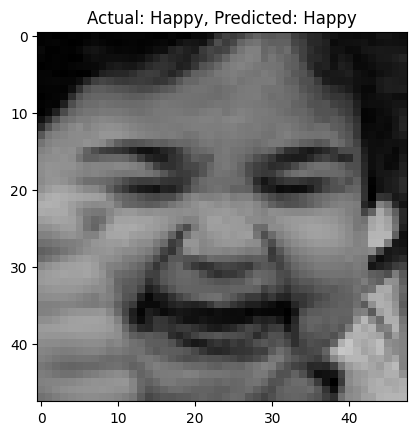

In [107]:

###########################
## Test on train data
cnn_classifier.eval()
# Define class names
class_names = ["Fear", "Happy", "Sad"]  # Add or modify as needed based on your classes
# Get a random index from the test set
random_index = random.randint(0, len(train_dataset) - 1)
# Get the image and label at the random index
image, label = train_dataset[random_index]
image = image.to(device)
label = label.to(device)

output = cnn_classifier(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Apply threshold for multiclass classification
_, predicted_label = torch.max(output, 1)

# Convert labels to class names
actual_class = class_names[int(label)]
predicted_class = class_names[int(predicted_label)]

# Check if the prediction is correct
is_correct = predicted_label == int(label)

# Print results
print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Correct: {is_correct}")

# Display the image
image = image.cpu().permute(1, 2, 0).numpy()  # Convert to numpy and rearrange dimensions
plt.imshow(image)
plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
plt.show()




## Test based off random image from test dataset


In [132]:

############
## call eval model
cnn_classifier.eval()

# Define class names
class_names = ["Fear", "Happy" ,"Sad"]  # Add or modify as needed

# Get a random index from the test set
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image and label at the random index
image, label = test_dataset[random_index]
image = image.to(device)
label = label.to(device)



Actual Class: Fear, Predicted Class: Fear, Correct: tensor([True], device='cuda:0')


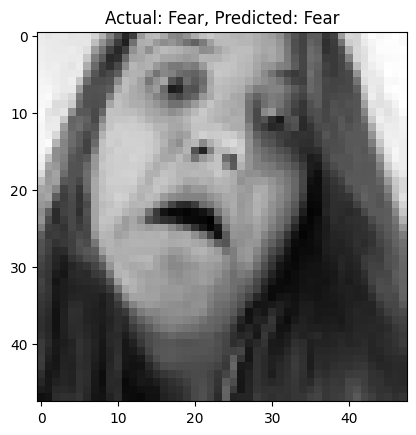

In [133]:

output = cnn_classifier(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Apply threshold for multiclass classification
_, predicted_label = torch.max(output, 1)

# Convert labels to class names
actual_class = class_names[int(label)]
predicted_class = class_names[int(predicted_label)]

# Check if the prediction is correct
is_correct = predicted_label == int(label)

# Print results
print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Correct: {is_correct}")

# Display the image
image = image.cpu().permute(1, 2, 0).numpy()  # Convert to numpy and rearrange dimensions
plt.imshow(image)
plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
plt.show()



In [112]:
import torch.onnx as onnx
import torchvision.models as models

dummy_input = torch.randn(1, 3, 48, 48).to(device)

# Export the model to ONNX format
onnx_path = "emotion_recognition_model.onnx"
torch.onnx.export(cnn_classifier, dummy_input, onnx_path, verbose=True, input_names=['input'], output_names=['output'])


In [125]:
#load model
#onnx_model = onnx.load(onnx_path)

#create runtime session
#ort_session = onnxruntime.InferenceSession(onnx_path)

#fill with dummy data
#input_data = dummy_input.cpu().numpy()

#run model with ONNX runtime
#ort_inputs={ort_session.get_inputs()[0].name: input_data}
#ort_outputs=ort_session.run(None, ort_inputs)

#print("Labels: ", train_loader)
#print("ONNX Runtime outputs", ort_outputs)